In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
data = np.load('norm-res-95.npy')
data = data.reshape(10046, 64, 64)
data_tensor = torch.Tensor(data).unsqueeze(1)  # Add channel dimension
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [3]:
# Constants
img_size = 64  # Image size (64x64)
img_channels =1 #1 for greyscale
latent_dim = 128  # Latent dimension for Generator and Encoder

In [4]:
# Define the Generator
# Define the Generator with CNN
class Generator(nn.Module):
    def __init__(self, latent_dim, img_channels, img_size):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [5]:
# Define the Discriminator
class DiscriminatorWithAutoencoder(nn.Module):
    def __init__(self, img_channels, img_size):
        super(DiscriminatorWithAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_size = img_size // 2 ** 4
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(64, img_channels, 4, stride=2, padding=1)
        )

        self.fc = nn.Sequential(
            nn.Linear(512 * ds_size ** 2, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        encoded = self.encoder(img)
        encoded_flat = encoded.view(encoded.size(0), -1)
        validity = self.fc(encoded_flat)
        decoded = self.decoder(encoded)
        return validity, encoded, decoded

In [6]:
# Define the Encoder using CNN
class Encoder(nn.Module):
    def __init__(self, img_channels, img_size, latent_dim):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
        )

        ds_size = img_size // 2 ** 4
        self.fc = nn.Linear(512 * ds_size ** 2, latent_dim)

    def forward(self, img):
        encoded = self.encoder(img)
        encoded_flat = encoded.view(encoded.size(0), -1)
        latent = self.fc(encoded_flat)
        return latent

In [7]:
# Initialize Encoder, Loss Function, and Optimizer
encoder = Encoder(img_channels, img_size, latent_dim).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(encoder.parameters(), lr=0.001,betas= (0.9,0.99))

In [8]:
# Load pre-trained models
gen = Generator(latent_dim, img_channels, img_size).cuda()
dis = DiscriminatorWithAutoencoder(img_channels, img_size).cuda()
gen.load_state_dict(torch.load('generatorwithCNN-res.pth'))
dis.load_state_dict(torch.load('discriminatorwithCNN-res.pth'))

<All keys matched successfully>

In [9]:
# Set models to evaluation mode
gen.eval()
dis.eval()

DiscriminatorWithAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=0.8, momentum=0.1, 

In [10]:
# Function to display images and their MSE
def display_images_and_mse(epoch):
    with torch.no_grad():
        data_sample, = next(iter(dataloader))
        data_sample = data_sample.cuda()  # Move to GPU
        latent_encoder_sample = encoder(data_sample)
        images_from_encoder = gen(latent_encoder_sample).detach()

        latent_random_sample = torch.randn(data_sample.size(0), 128).cuda()  # Move to GPU
        images_from_gen = gen(latent_random_sample).detach()

        output_discriminator_encoder, _, _ = dis(images_from_encoder)
        output_discriminator_gen, _, _ = dis(images_from_gen)

        output_discriminator_encoder = output_discriminator_encoder.detach()
        output_discriminator_gen = output_discriminator_gen.detach()

        mse_images = criterion(images_from_encoder, images_from_gen).item()

        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        for i in range(5):
            axes[0, i].imshow(images_from_encoder[i].cpu().squeeze(0), cmap='gray')
            axes[0, i].set_title(f"Enc: {output_discriminator_encoder[i].item():.2f}")
            axes[0, i].axis('off')

            axes[1, i].imshow(images_from_gen[i].cpu().squeeze(0), cmap='gray')
            axes[1, i].set_title(f"Gen: {output_discriminator_gen[i].item():.2f}")
            axes[1, i].axis('off')

        plt.suptitle(f'Epoch {epoch + 1}, MSE Between Images: {mse_images:.4f}')
        plt.show()

Epoch 125/250: 100%|████████████████| 157/157 [00:30<00:00,  5.17batch/s, feat_loss=0.118, img_loss=0.0621, loss=0.181]


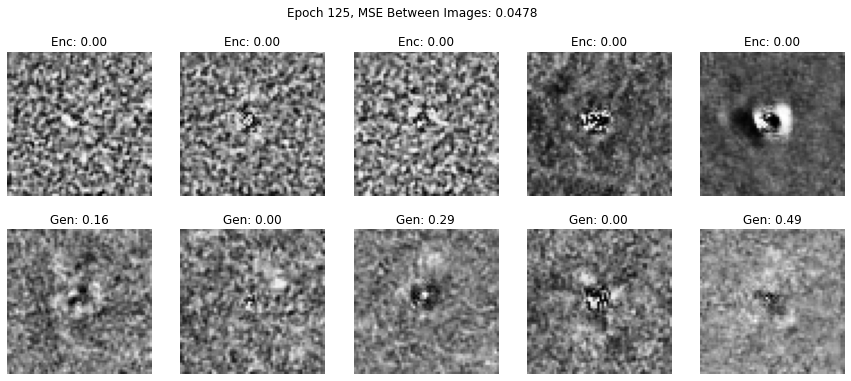

Epoch 187/250: 100%|██████████████████| 157/157 [00:24<00:00,  6.41batch/s, feat_loss=0.08, img_loss=0.057, loss=0.137]


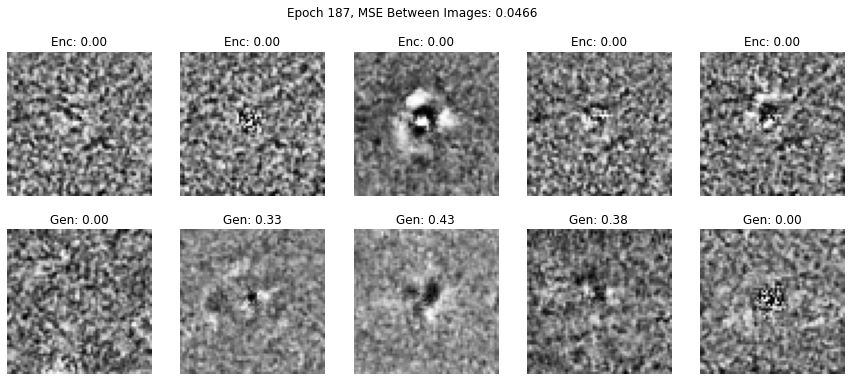

Epoch 250/250: 100%|███████████████| 157/157 [00:23<00:00,  6.63batch/s, feat_loss=0.0715, img_loss=0.0565, loss=0.128]


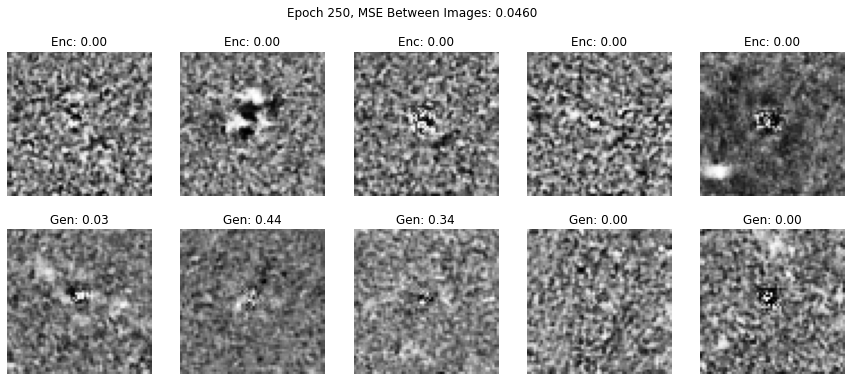

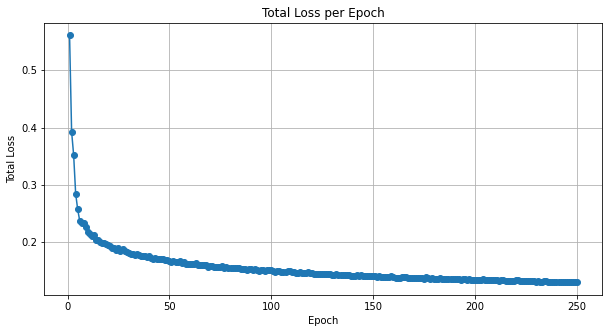

In [11]:
import matplotlib.pyplot as plt

# Initialize a list to store the total loss for each epoch
losses_per_epoch = []

# Training Loop
num_epochs = 250
for epoch in range(num_epochs):
    total_loss = 0  # Initialize total loss for this epoch
    num_batches = 0  # Initialize batch count for averaging loss per epoch

    with tqdm(dataloader, unit="batch", desc=f"Epoch {epoch + 1}/{num_epochs}") as tepoch:
        for data_batch, in tepoch:
            data_batch = data_batch.cuda()  # Ensure data_batch is 4D with shape [batch_size, 1, 64, 64]

            # Generate latent vectors using the Encoder
            latent_vectors = encoder(data_batch)

            # Generate images using the Generator
            generated_images = gen(latent_vectors)

            # Compute the new image loss
            img_loss = torch.mean((data_batch - generated_images) ** 2)

            # Pass the original image through the Encoder and Generator
            latent_representation = encoder(data_batch)
            generated_img = gen(latent_representation)

            # Get feature vectors from the Discriminator
            _, original_features, _ = dis(data_batch)
            _, generated_features, _ = dis(generated_img)

            # Compute the new feature loss
            feat_loss = torch.mean((original_features - generated_features) ** 2)

            # Combine the new image loss and the new feature loss
            loss = img_loss + feat_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item(), img_loss=img_loss.item(), feat_loss=feat_loss.item())

            # Accumulate total loss and batch count
            total_loss += loss.item()
            num_batches += 1

        # Calculate and store the average loss for this epoch
        avg_loss = total_loss / num_batches
        losses_per_epoch.append(avg_loss)

        # Display images and MSE at 50%, 75%, and 100% of epochs
        if epoch == num_epochs // 2 - 1 or epoch == int(num_epochs * 0.75) - 1 or epoch == num_epochs - 1:
            display_images_and_mse(epoch)

# Plot the total loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses_per_epoch, marker='o')
plt.title('Total Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True)
plt.show()


In [12]:
# Prepare the data with epoch numbers
losses_per_epoch_with_epochs = [{"epoch": epoch + 1, "loss": loss} for epoch, loss in enumerate(losses_per_epoch)]

# Save the data to a JSON file
with open('losses_per_epoch.json', 'w') as f:
    json.dump(losses_per_epoch_with_epochs, f)

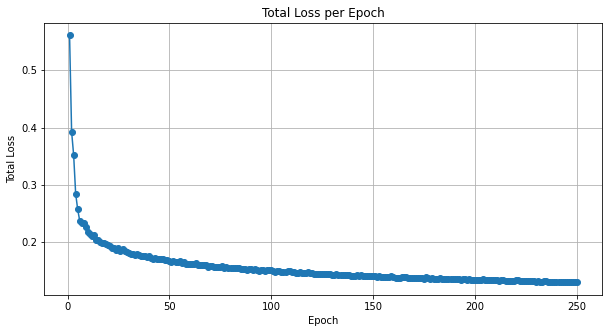

In [13]:
# Load the data from the JSON file
with open('losses_per_epoch.json', 'r') as f:
    losses_per_epoch_with_epochs = json.load(f)

# Extract epoch numbers and losses from the loaded data
epochs = [entry['epoch'] for entry in losses_per_epoch_with_epochs]
losses = [entry['loss'] for entry in losses_per_epoch_with_epochs]

# Plot the total loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, marker='o')
plt.title('Total Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True)
plt.show()


In [14]:
torch.save(encoder.state_dict(), 'trained_encoder_cnn-res.pth')

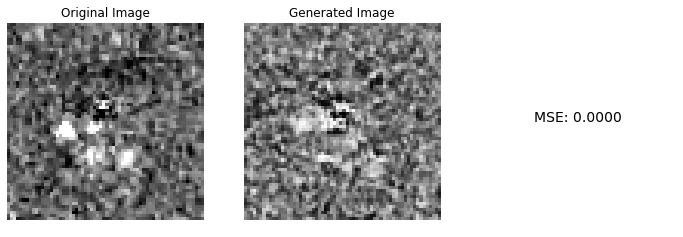

In [15]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

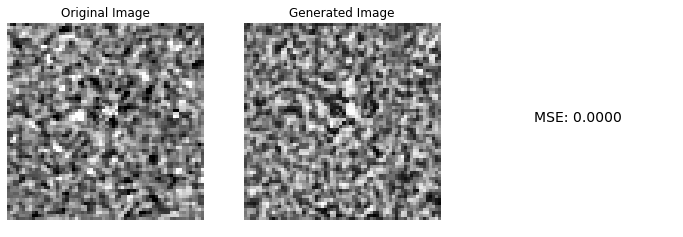

In [16]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

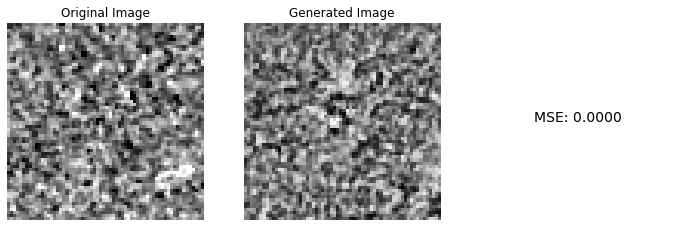

In [17]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

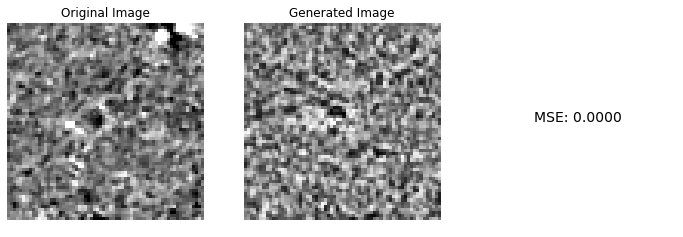

In [18]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

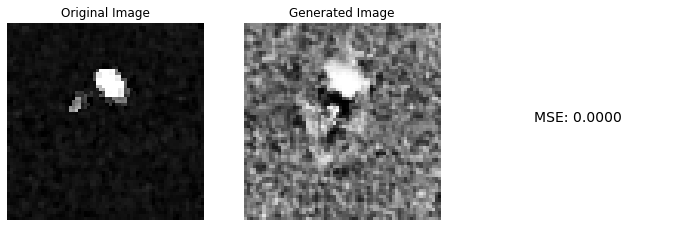

In [19]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

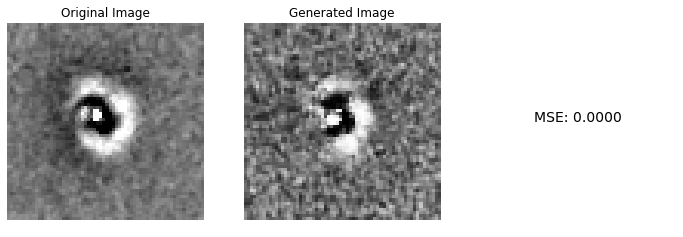

In [20]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

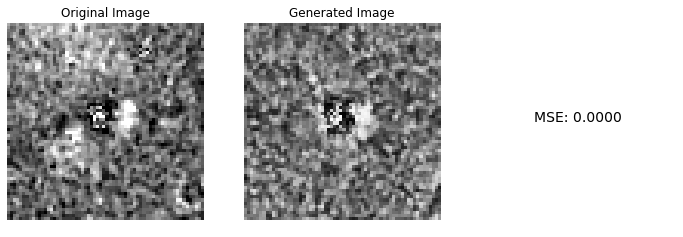

In [21]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

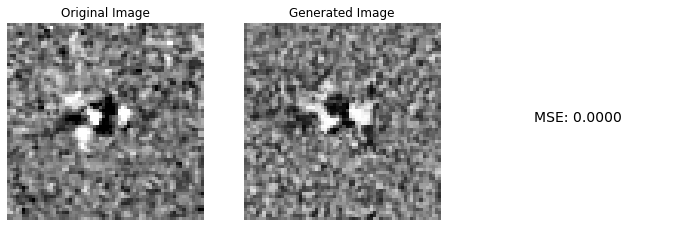

In [22]:
# Process a Random Image through Encoder, Generator, and Discriminator
with torch.no_grad():
    random_index = np.random.randint(len(dataset))  # Select a random index
    random_image, = dataset[random_index]  # Get the random image
    random_image = random_image.cuda()  # Move to GPU
    random_image_latent = encoder(random_image.unsqueeze(0))  # Generate latent space
    generated_image = gen(random_image_latent)
    
# Discriminator Output
output_discriminator, _, _ = dis(generated_image)
mse_from_discriminator = criterion(output_discriminator, torch.zeros_like(output_discriminator)).item()

# Plotting the original, generated images, and MSE
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(random_image.cpu().squeeze(), cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(generated_image.cpu().detach().squeeze(), cmap='gray')
plt.title("Generated Image")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.text(0.5, 0.5, f'MSE: {mse_from_discriminator:.4f}', fontsize=14, ha='center')
plt.axis('off')

plt.show()

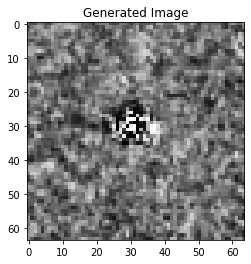

In [23]:
# Image generated from the encoder's latent space
with torch.no_grad():
    # Get a random real image from the dataset
    random_index = np.random.randint(len(dataset))
    real_image = dataset[random_index][0]  # Access the image tensor

    # Move the real image to the GPU
    real_image = real_image.cuda()

    # Pass the real image through the encoder
    encoder_output = encoder(real_image.unsqueeze(0))  # Add batch dimension

    # Pass the encoder output through the generator
    generated_image = gen(encoder_output)

    # Access the tensor inside the tuple and print the generator's output
    generated_image_tensor = generated_image[0]
    generated_image_np = generated_image_tensor.cpu().numpy().reshape((64, 64))

    # Display the generated image
    plt.imshow(generated_image_np, cmap='gray')
    plt.title("Generated Image")
    plt.show()


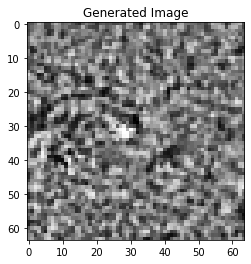

In [24]:
# Image generated from the encoder's latent space
with torch.no_grad():
    # Get a random real image from the dataset
    random_index = np.random.randint(len(dataset))
    real_image = dataset[random_index][0]  # Access the image tensor

    # Move the real image to the GPU
    real_image = real_image.cuda()

    # Pass the real image through the encoder
    encoder_output = encoder(real_image.unsqueeze(0))  # Add batch dimension

    # Pass the encoder output through the generator
    generated_image = gen(encoder_output)

    # Access the tensor inside the tuple and print the generator's output
    generated_image_tensor = generated_image[0]
    generated_image_np = generated_image_tensor.cpu().numpy().reshape((64, 64))

    # Display the generated image
    plt.imshow(generated_image_np, cmap='gray')
    plt.title("Generated Image")
    plt.show()


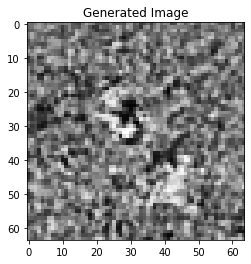

In [25]:
# Image generated from the encoder's latent space
with torch.no_grad():
    # Get a random real image from the dataset
    random_index = np.random.randint(len(dataset))
    real_image = dataset[random_index][0]  # Access the image tensor

    # Move the real image to the GPU
    real_image = real_image.cuda()

    # Pass the real image through the encoder
    encoder_output = encoder(real_image.unsqueeze(0))  # Add batch dimension

    # Pass the encoder output through the generator
    generated_image = gen(encoder_output)

    # Access the tensor inside the tuple and print the generator's output
    generated_image_tensor = generated_image[0]
    generated_image_np = generated_image_tensor.cpu().numpy().reshape((64, 64))

    # Display the generated image
    plt.imshow(generated_image_np, cmap='gray')
    plt.title("Generated Image")
    plt.show()


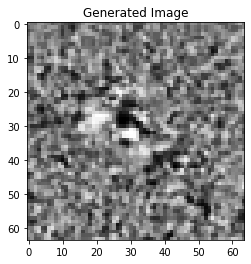

In [26]:
# Image generated from the encoder's latent space
with torch.no_grad():
    # Get a random real image from the dataset
    random_index = np.random.randint(len(dataset))
    real_image = dataset[random_index][0]  # Access the image tensor

    # Move the real image to the GPU
    real_image = real_image.cuda()

    # Pass the real image through the encoder
    encoder_output = encoder(real_image.unsqueeze(0))  # Add batch dimension

    # Pass the encoder output through the generator
    generated_image = gen(encoder_output)

    # Access the tensor inside the tuple and print the generator's output
    generated_image_tensor = generated_image[0]
    generated_image_np = generated_image_tensor.cpu().numpy().reshape((64, 64))

    # Display the generated image
    plt.imshow(generated_image_np, cmap='gray')
    plt.title("Generated Image")
    plt.show()


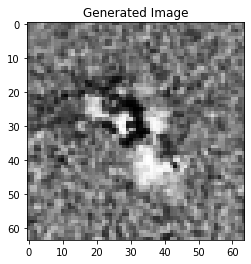

In [27]:
# Image generated from the encoder's latent space
with torch.no_grad():
    # Get a random real image from the dataset
    random_index = np.random.randint(len(dataset))
    real_image = dataset[random_index][0]  # Access the image tensor

    # Move the real image to the GPU
    real_image = real_image.cuda()

    # Pass the real image through the encoder
    encoder_output = encoder(real_image.unsqueeze(0))  # Add batch dimension

    # Pass the encoder output through the generator
    generated_image = gen(encoder_output)

    # Access the tensor inside the tuple and print the generator's output
    generated_image_tensor = generated_image[0]
    generated_image_np = generated_image_tensor.cpu().numpy().reshape((64, 64))

    # Display the generated image
    plt.imshow(generated_image_np, cmap='gray')
    plt.title("Generated Image")
    plt.show()


In [28]:
import torch
import numpy as np

with torch.no_grad():
    # Get a random image from the dataset
    random_index = np.random.randint(len(dataset))
    random_image, = dataset[random_index]  # Note the comma to unpack the tensor

    # Move the random image to the GPU and maintain its shape
    random_image = random_image.cuda().unsqueeze(0)  # Add batch dimension

    # Generate a latent vector from the encoder
    latent_vector_from_encoder = encoder(random_image)
    
    # Generate an image from this latent vector
    generated_image_from_encoder = gen(latent_vector_from_encoder)

    # Pass this image through the discriminator
    discriminator_output, _, _ = dis(generated_image_from_encoder)

    # Access the tensor inside the tuple and print the discriminator's confidence
    discriminator_output_tensor = discriminator_output
    confidence = discriminator_output_tensor.item()

    print(f"Discriminator's confidence on encoder image (real=1, fake=0): {confidence}")


Discriminator's confidence on encoder image (real=1, fake=0): 1.1530377378221601e-05


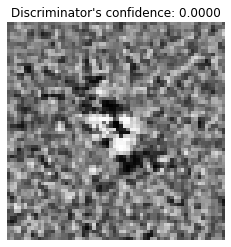

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generating from Encoder's latent space
with torch.no_grad():
    # Get a random image from the dataset
    random_index = np.random.randint(len(dataset))
    random_image, = dataset[random_index]  # Note the comma to unpack the tensor

    # Move the random image to the GPU and maintain its shape
    random_image = random_image.cuda().unsqueeze(0)  # Add batch dimension

    # Generate a latent vector from the encoder
    latent_vector_from_encoder = encoder(random_image)
    
    # Generate an image from this latent vector
    generated_image_from_encoder = gen(latent_vector_from_encoder)

    # Pass this image through the discriminator
    discriminator_output, _, _ = dis(generated_image_from_encoder)

    # Get the discriminator's confidence
    confidence = discriminator_output.item()

    # Convert the generated image tensor to a numpy array and reshape
    generated_image_np = generated_image_from_encoder.cpu().numpy().reshape((64, 64))

    # Display the generated image along with the discriminator's confidence
    plt.imshow(generated_image_np, cmap='gray')
    plt.title(f"Discriminator's confidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()


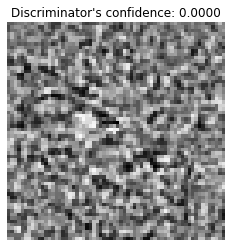

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generating from Encoder's latent space
with torch.no_grad():
    # Get a random image from the dataset
    random_index = np.random.randint(len(dataset))
    random_image, = dataset[random_index]  # Note the comma to unpack the tensor

    # Move the random image to the GPU and maintain its shape
    random_image = random_image.cuda().unsqueeze(0)  # Add batch dimension

    # Generate a latent vector from the encoder
    latent_vector_from_encoder = encoder(random_image)
    
    # Generate an image from this latent vector
    generated_image_from_encoder = gen(latent_vector_from_encoder)

    # Pass this image through the discriminator
    discriminator_output, _, _ = dis(generated_image_from_encoder)

    # Get the discriminator's confidence
    confidence = discriminator_output.item()

    # Convert the generated image tensor to a numpy array and reshape
    generated_image_np = generated_image_from_encoder.cpu().numpy().reshape((64, 64))

    # Display the generated image along with the discriminator's confidence
    plt.imshow(generated_image_np, cmap='gray')
    plt.title(f"Discriminator's confidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()


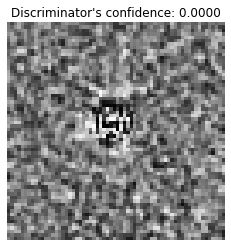

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Generating from Encoder's latent space
with torch.no_grad():
    # Get a random image from the dataset
    random_index = np.random.randint(len(dataset))
    random_image, = dataset[random_index]  # Note the comma to unpack the tensor

    # Move the random image to the GPU and maintain its shape
    random_image = random_image.cuda().unsqueeze(0)  # Add batch dimension

    # Generate a latent vector from the encoder
    latent_vector_from_encoder = encoder(random_image)
    
    # Generate an image from this latent vector
    generated_image_from_encoder = gen(latent_vector_from_encoder)

    # Pass this image through the discriminator
    discriminator_output, _, _ = dis(generated_image_from_encoder)

    # Get the discriminator's confidence
    confidence = discriminator_output.item()

    # Convert the generated image tensor to a numpy array and reshape
    generated_image_np = generated_image_from_encoder.cpu().numpy().reshape((64, 64))

    # Display the generated image along with the discriminator's confidence
    plt.imshow(generated_image_np, cmap='gray')
    plt.title(f"Discriminator's confidence: {confidence:.4f}")
    plt.axis('off')
    plt.show()